In [1]:
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
import opendatasets as od
from pathlib import Path
from collections import Counter
from collections import Counter
from sklearn.metrics import precision_score,recall_score

C:\Users\haeun\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\haeun\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
source_path = "/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
data_dir = Path('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/')


train_dir = data_dir / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train_dir

datasets="https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone"

In [ ]:
od.download(datasets)
splitfolders.ratio("data", output="dataset",seed=831, ratio=(.8, 0.1,0.1)) 

In [2]:
trans=transforms.Compose([transforms.Resize((224,224)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                         ])

In [3]:
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=16,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=False)

In [4]:

classifier = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
classifier.fc=nn.Linear(2048,4)

Text(0.5, 1.0, '               Tumor,                  Cyst,                Normal,                Normal,                  Cyst,                  Cyst,                 Stone,                 Tumor,                Normal,                 Tumor,                 Tumor,                Normal,                 Tumor,                Normal,                Normal,                Normal, ')

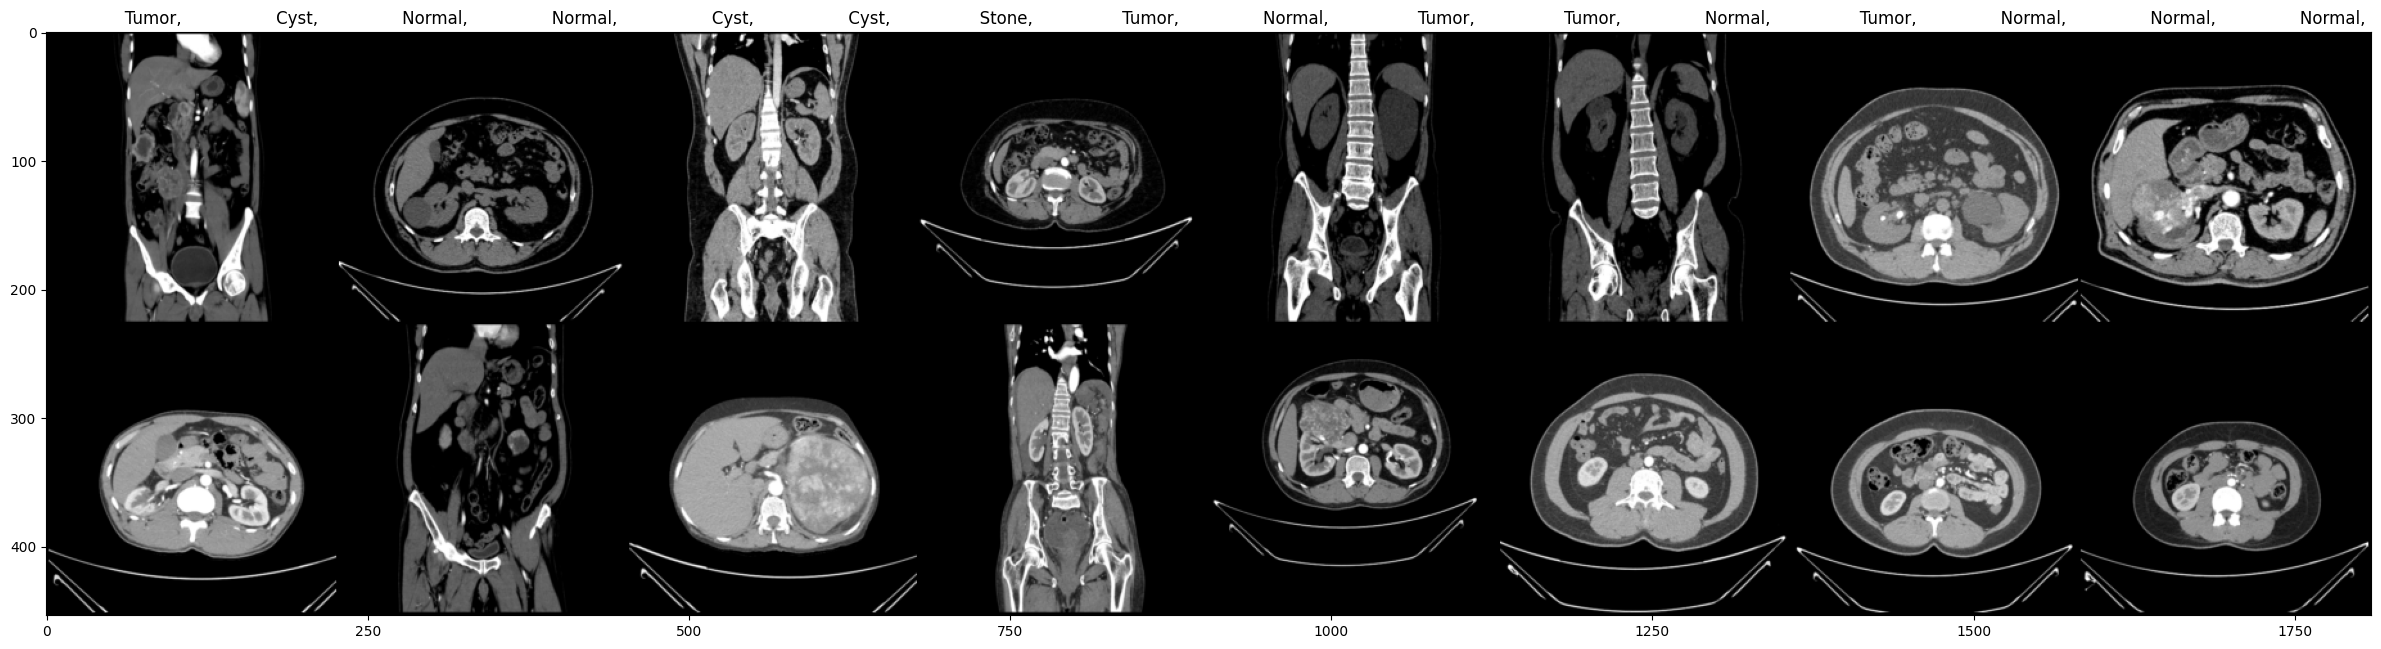

In [5]:
classes=(train_dataset.classes)

fig = plt.figure(figsize=(30, 30))

images,labels=next(iter(train_loader))
img = images / 2 + 0.5 
grid_img = torchvision.utils.make_grid(img)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

plt.title(' '.join('%20s, ' % classes[labels[j]] for j in range(len(labels))))


In [6]:
import pandas as pd
data=pd.read_csv('kidneyData.csv')

print(data.shape)
data

(12446, 6)


Unnamed: 0       image_id  \
0               0  Tumor- (1044)   
1               1    Tumor- (83)   
2               2   Tumor- (580)   
3               3  Tumor- (1701)   
4               4  Tumor- (1220)   
...           ...            ...   
12441       12441   Cyst- (2522)   
12442       12442   Cyst- (2627)   
12443       12443    Cyst- (972)   
12444       12444   Cyst- (2323)   
12445       12445   Cyst- (2145)   

                                                    path   diag  target  Class  
0      /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
1      /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
2      /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
3      /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
4      /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
...                                                  ...    ...     ...    ...  
12441  /content/data/CT KIDNEY DATASET Normal, CYST, ...   Cyst       0   Cyst  
12442  /content/data/CT KIDNEY DATASET Normal, CYST, ...   Cyst       0   Cyst  
12443  /content/data/CT KIDNEY DATASET Normal, CYST, ...   Cyst       0   Cyst  
12444  /content/data/CT KIDNEY DATASET Normal, CYST, ...   Cyst       0   Cyst  
12445  /content/data/CT KIDNEY DATASET Normal, CYST, ...   Cyst       0   Cyst  

[12446 rows x 6 columns]

In [7]:
category=np.unique(data['Class'])
category
id,count=np.unique(data['Class'],return_counts=True)
id,count

(array(['Cyst', 'Normal', 'Stone', 'Tumor'], dtype=object),
 array([3709, 5077, 1377, 2283], dtype=int64))

In [8]:
median=np.median(count)
class_weight=[]
for i in range(len(category)):
    print(f'{category[i]} : {median/count[i]}')
    class_weight.append(median/count[i])
class_weight=torch.FloatTensor(class_weight)

Cyst : 0.8077648961984363
Normal : 0.5901122710261966
Stone : 2.175744371822803
Tumor : 1.3123083661848445


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device
a=[1,2,3,1,2,3]
b=[1,3,2,1,2,3]
tensor_a=torch.FloatTensor(a)
tensor_b=torch.FloatTensor(b)
precision_score(tensor_a.cpu().numpy(),tensor_b.cpu().numpy(),average='micro')

0.6666666666666666

In [10]:



def train_eval(optimizer,device,classifier,epochs,class_weight,train_loader,valid_loader):
#confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=3)
    run = wandb.init(project=f"kidney_classification")
    classifier.train()
    classifier=classifier.to(device)
    class_weight=class_weight.to(device)
    for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        train_total_accuracy=0.0
        for image,labels in tqdm(train_loader):
            
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            _,predicted=torch.max(output,1)
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total_accuracy+=(predicted == labels).sum().item() 
            
        wandb.log({
        'average_train_loss': train_total_loss/num_batch,
        'average_train_accuracy' :train_total_accuracy/len(train_loader)    
            })
        classifier.eval()
        val_total_loss=0.0
        val_total_accuracy=0.0
        val_total_precision=0.0
        val_total_recall=0.0
        with torch.no_grad():
            for image,labels in tqdm(valid_loader):
                
                image=image.to(device)
                labels=labels.to(device)
                output=classifier(image)
                loss=F.cross_entropy(output,labels,weight=class_weight)
                
                _,predicted=torch.max(output,1)
               
                val_total_loss+=loss.item()
                val_total_accuracy+=(predicted == labels).sum().item() 
                val_total_precision+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='micro')
                val_total_recall+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='micro')
        wandb.log({
        'average_val_loss': val_total_loss/num_batch,
        'average_val_accuracy' :val_total_accuracy/len(valid_loader),    
        'average_val_precision' :val_total_precision/num_batch,
        'average_val_recall' :val_total_recall/num_batch
        })



In [11]:

sweep_config={
'name' : 'parameter_tuning',
'method': 'grid',
'metric': {'name': 'val_loss','goal' :'minimize'},
'parameters':{
    'learning_rate' :
     {'values': [10**-5,10**-3,10**-1]},
    'epochs': 
    {'values':[10,50,100]},
    
    }
}




In [12]:
def run_sweep(config=None):
    epoches=10
    
    wandb.init(config=config)
    wandb_config=wandb.config
    loss=nn.CrossEntropyLoss(weight=class_weight)
    train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
    valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
    test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
    train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
    valid_loader=DataLoader(valid_dataset,batch_size=16,shuffle=False)
    test_loader=DataLoader(test_dataset,batch_size=16,shuffle=False)
    optimizer=torch.optim.Adam(classifier.parameters(),lr=wandb_config.learning_rate)
    train_eval(optimizer,device,classifier,wandb_config.epochs,class_weight,train_loader,valid_loader)      

In [ ]:
sweep_id=wandb.sweep(sweep_config,project='kidney classification')
wandb.agent(sweep_id,run_sweep)
wandb.finish()

Create sweep with ID: c700jtgz
Sweep URL: https://wandb.ai/k9789544219/kidney%20classification/sweeps/c700jtgz


wandb: Agent Starting Run: j34wpect with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: Currently logged in as: k9789544219. Use `wandb login --relogin` to force relogin


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 623/623 [25:21<00:00,  2.44s/it]

100%|██████████| 623/623 [24:46<00:00,  2.39s/it]

100%|██████████| 623/623 [23:59<00:00,  2.31s/it]

100%|██████████| 623/623 [23:44<00:00,  2.29s/it]

100%|██████████| 623/623 [23:46<00:00,  2.29s/it]

100%|██████████| 623/623 [23:46<00:00,  2.29s/it]

100%|██████████| 623/623 [24:14<00:00,  2.33s/it]

100%|██████████| 623/623 [23:50<00:00,  2.30s/it]

100%|██████████| 623/623 [23:53<00:00,  2.30s/it]

100%|██████████| 623/623 [23:51<00:00,  2.30s/it]

100%|██████████| 10/10 [4:11:47<00:00, 1510.75s/it]


wandb: Agent Starting Run: q9wbzhbm with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 623/623 [24:14<00:00,  2.33s/it]

100%|██████████| 623/623 [23:23<00:00,  2.25s/it]

100%|██████████| 623/623 [23:26<00:00,  2.26s/it]

100%|██████████| 623/623 [23:27<00:00,  2.26s/it]

100%|██████████| 623/623 [23:28<00:00,  2.26s/it]

100%|██████████| 623/623 [23:29<00:00,  2.26s/it]

100%|██████████| 623/623 [23:50<00:00,  2.30s/it]

100%|██████████| 623/623 [25:57<00:00,  2.50s/it]

100%|██████████| 623/623 [25:57<00:00,  2.50s/it]

100%|██████████| 623/623 [25:19<00:00,  2.44s/it]

100%|██████████| 10/10 [4:13:15<00:00, 1519.58s/it]


wandb: Agent Starting Run: 4tp73xjk with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 623/623 [24:15<00:00,  2.34s/it]

100%|██████████| 623/623 [23:31<00:00,  2.26s/it]

100%|██████████| 623/623 [23:33<00:00,  2.27s/it]

100%|██████████| 623/623 [23:41<00:00,  2.28s/it]

100%|██████████| 623/623 [23:41<00:00,  2.28s/it]

100%|██████████| 623/623 [23:44<00:00,  2.29s/it]

100%|██████████| 623/623 [23:46<00:00,  2.29s/it]

100%|██████████| 623/623 [23:57<00:00,  2.31s/it]

100%|██████████| 623/623 [23:58<00:00,  2.31s/it]

100%|██████████| 623/623 [23:59<00:00,  2.31s/it]

100%|██████████| 10/10 [4:08:45<00:00, 1492.59s/it]


wandb: Agent Starting Run: d8lwmqiy with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 623/623 [27:51<00:00,  2.68s/it]

100%|██████████| 623/623 [26:14<00:00,  2.53s/it]

100%|██████████| 623/623 [23:42<00:00,  2.28s/it]

100%|██████████| 623/623 [24:33<00:00,  2.36s/it]

100%|██████████| 623/623 [24:52<00:00,  2.40s/it]

100%|██████████| 623/623 [24:56<00:00,  2.40s/it]

100%|██████████| 623/623 [24:54<00:00,  2.40s/it]

100%|██████████| 623/623 [24:06<00:00,  2.32s/it]

100%|██████████| 623/623 [23:47<00:00,  2.29s/it]

100%|██████████| 623/623 [23:55<00:00,  2.30s/it]

100%|██████████| 623/623 [23:58<00:00,  2.31s/it]

100%|██████████| 623/623 [24:02<00:00,  2.32s/it]

100%|██████████| 623/623 [24:13<00:00,  2.33s/it]

100%|██████████| 623/623 [24:12<00:00,  2.33s/it]

100%|██████████| 623/623 [24:21<00:00,  2.35s/it]

100%|██████████| 623/623 [24:25<00:00,  2.35s/it]

100%|██████████| 623/623 [24:28<00:00,  2.36s/it]

100%|██████████| 623/623 [24:33<00:00,  2.36s/it]

100%|██████████| 623/623 [24:35<00:00,  2.37s/it]

100%|██████████| 623/623 [24:44